# Predicting the political bias of news articles with linear models

## Load Preprocessed Text

In [90]:
#import pandas
import pandas as pd 

# define csv read
def read_data2(filename):
    # read in csv
    df = pd.read_csv(filename, sep='\t', encoding='utf-8')
    
    #drop first column (index)
    df = df.drop(df.columns[0], axis=1)
    
    return df

# load cleaned file with sentiment data
new = read_data2('webhose-corpus-df-clean.csv')
new.head()

,bias,source,headline,text,date,sentences,reading,length
0,3,Washington Times,group sues county permit oil refinery near park,print thursday june bismarck ap dakota resourc...,2018-06-15,10,13.2,145
1,3,Breitbart,man claims asked leave restaurant wearing larg...,man claims asked leave restaurant wearing larg...,2018-06-10,17,10.8,360
2,1,New York Times,able handle hbo,media analysts tech industry prognosticators l...,2018-06-14,73,10.2,1231
3,1,New York Times,summer skiing getaways southern hemisphere,summer popular time beach vacations sun water ...,2018-06-05,27,11.1,513
4,1,New York Times,fact check corey stewart republicans fringe right,fact check corey stewart republicans fringe ri...,2018-06-14,80,11.5,1173


In [91]:
## load test corpus
test_corpus = read_data2('news-corpus-df-clean.csv')
test_corpus.head()

,bias,text,headline,source,date,sentiment,magnitude,sentences,length,reading
0,1,melania trump appears plagiarized speech openi...,melania trump plagiarized michelle obama woman...,Daily Beast,2016-07-19,0.0,13.1,51,901,11.4
1,1,federal communications commission took aim sig...,fcc plan would give internet providers power c...,Washington Post,2017-11-21,-0.1,11.0,39,957,16.4
2,1,radical idea live miles south canadian border ...,opinion bernie sanders need medicare,New York Times,2017-09-13,0.0,3.0,18,379,12.6
3,3,democrats indicated sunday decision attorney g...,attorney general jeff sessions testify senate ...,Washington Times,2017-06-12,-0.1,9.9,86,1096,11.7
4,1,california highway patrol takes pride able saf...,lapd chief mayor warn taking anti trump protes...,Los Angeles Times,2016-11-10,0.0,0.6,2,62,19.8


### Remove Short Texts

In [92]:
import seaborn as sns

(0, 3000)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


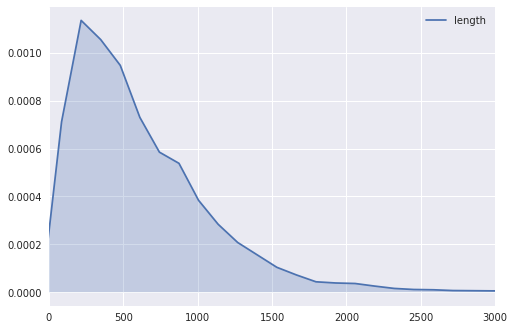

In [93]:
# get density plot of text length
lengthplot = sns.kdeplot(new.length, shade=True);
axes = lengthplot.axes 
axes.set_xlim(0,3000)

In [94]:
# examine distribution of text lengths
from scipy import stats
print(stats.describe(new.length))

DescribeResult(nobs=31184, minmax=(1, 16347), mean=611.6549833247819, variance=378989.9508374945, skewness=6.3243737752776585, kurtosis=98.82363857350938)


In [95]:
# how many texts in the dataset under/over a certain length?
print('Under 100 words: ', len(new[new.length < 100]))
print('Over 2500 words: ', len(new[new.length > 2000]))

Under 100 words:  2179
Over 2500 words:  680


In [96]:
# clip dataset of overly short / lengthy texts
new = new[new.length > 100]
new = new[new.length < 2000]

### Assess Readability Across Bias Groups

(0, 30)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


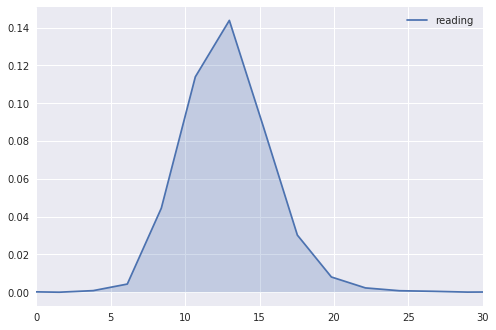

In [97]:
import seaborn as sns
readplot = sns.kdeplot(new.reading, shade=True);
axes = readplot.axes 
axes.set_xlim(0,30)

In [98]:
#new.groupby('bias')['reading'].mean()
new['reading'].groupby(new['bias']).describe()

,count,mean,std,min,25%,50%,75%,max
bias,,,,,,,,
1,9406.0,12.666532,3.468662,0.4,10.7,12.5,14.3,132.6
2,9389.0,12.960006,5.548951,2.2,10.5,12.7,14.9,288.4
3,9502.0,13.007788,2.762224,1.5,11.2,12.8,14.5,49.2


In [99]:
#new['reading'].groupby(new['bias']).plot.kde();

### Equalize Bias Groups

**Note**: Decided not to implement.

In [100]:
# check num of center labeled stories
print('Left: ', new.loc[new['bias'] == 1].shape[0])
print('Center: ', new.loc[new['bias'] == 2].shape[0])
print('Right: ', new.loc[new['bias'] == 3].shape[0])

Left:  9406
Center:  9389
Right:  9502


### Define Features

In [101]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [102]:
# get text function
def get_text(X):
  return X['text'].values

# get source function
def get_source(X):
  return X['source'].values

# get bias function
def get_bias(y):
  return y['bias'].values

### Create a Pipeline Incorporating Multiple Features

In [103]:
from sklearn.svm import LinearSVC

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.4, min_df = 0.05, sublinear_tf=True, norm='l2' )), 
        ])),
        ('source', Pipeline([
            ('get_text', FunctionTransformer(get_source, validate=False)),
            ('tfidf2', TfidfVectorizer(ngram_range=(1,5), sublinear_tf=True, norm='l2' )), 
        ])),
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 1,
            'source': 1.5,
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [60]:
# create training and test sets
from sklearn.model_selection import train_test_split

# subset data frame into features and outcomes
features = new.loc[:, ['text', 'source']]
outcomes = new.loc[:, ['bias']]

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [61]:
# fit model and test predictions
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)

In [63]:
accuracy = np.mean(predicted == y_test)
print(accuracy)

1.0


### Add More Features

In [104]:
# get headline function
def get_headline(X):
  return X['headline'].values

# get date function
def get_date(X):
  date = X.date.values
  return np.array([int(x[:4]) for x in date]).reshape(-1, 1)

# get num of sentences
def get_sentences(X):
  num_sent = X['sentences']
  return np.array(num_sent).reshape(-1, 1)

# get text length
def get_text_len(X):
  text_len = X['length'].values
  return np.array(text_len).reshape(-1, 1)

# get readability
def get_read(X):
  read = X['reading'].values
  return np.array(read).reshape(-1, 1)

### Pipeline 2: Classification without Source

In [79]:
from sklearn.svm import LinearSVC

classifier2 = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.4, min_df = 0.05, sublinear_tf=True, norm='l2' )), 
        ])),
      
        ('sentences', Pipeline([
            ('get_sentences', FunctionTransformer(get_sentences, validate=False)),
        ])),
      
        ('read', Pipeline([
            ('get_read', FunctionTransformer(get_read, validate=False)),
        ])),
      
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 1.5,
            'sentences':0.5,
            'read':0.5,
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [80]:
# create training and test sets
from sklearn.model_selection import train_test_split

# subset data frame into features and outcomes
# features = new.loc[:, ['text', 'headline', 'source', 'date', 'sentiment', 'magnitude', 'length', 'sentences']]
features = new.loc[:, ['text', 'sentences', 'reading']]
outcomes = new.loc[:, ['bias']]

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [81]:
# fit model and test predictions
classifier2.fit(X_train, y_train)
predicted = classifier2.predict(X_test)

In [82]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.8510600706713781


### Generalize to All Sides Data?

In [106]:
# subset data frame into features and outcomes
# features = new.loc[:, ['text', 'headline', 'source', 'date', 'sentiment', 'magnitude', 'length', 'sentences']]
X_train = new.loc[:, ['text', 'sentences', 'reading']]
y_train = new.loc[:, ['bias']]

X_test = test_corpus.loc[:, ['text', 'sentences', 'reading']]
y_test = test_corpus.loc[:, ['bias']]

y_train, y_test = get_bias(y_train), get_bias(y_test)

In [107]:
# fit model and test predictions
classifier2.fit(X_train, y_train)
predicted = classifier2.predict(X_test)

In [108]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.47850821744627053


### Pipeline 2: Stratified k-Folds Cross-Validation

In [153]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=10, shuffle=True)

# Loop through the indices the split() method returns
cum_val = []

for index, (train_indices, val_indices) in enumerate(skf.split(features, outcomes)):
    print("Training on fold ", str(index+1), "/10...")
    
    # Generate batches from indices
    xtrain, xval = features.iloc[train_indices], features.iloc[val_indices]
    ytrain, yval = outcomes.iloc[train_indices], outcomes.iloc[val_indices]
    
    # Debug message
    print("Training new iteration on ", str(xtrain.shape[0]), " training samples, ", str(xval.shape[0]), " validation samples, this may be a while...")
    
    classifier2.fit(xtrain, ytrain)
    
    train_pred = classifier2.predict(xtrain)
    train_accuracy = np.mean(train_pred == ytrain['bias'].values)    
    
    val_pred = classifier2.predict(xval)
    val_accuracy = np.mean(val_pred == yval['bias'].values)
    
    cum_val.append(val_accuracy)
    cum_acc = np.mean(cum_val)
    
    print("Last training accuracy: ", str(train_accuracy), ", last validation accuracy: ", str(val_accuracy))
    print("Stratified 10-fold validation accuracy: ", str(cum_acc))

Training on fold  1 /10...
Training new iteration on  2493  training samples,  278  validation samples, this may be a while...
Last training accuracy:  0.8588046530284797 , last validation accuracy:  0.6294964028776978
Stratified 10-fold validation accuracy:  0.6294964028776978
Training on fold  2 /10...
Training new iteration on  2493  training samples,  278  validation samples, this may be a while...
Last training accuracy:  0.8680304853590052 , last validation accuracy:  0.6402877697841727
Stratified 10-fold validation accuracy:  0.6348920863309353
Training on fold  3 /10...
Training new iteration on  2493  training samples,  278  validation samples, this may be a while...
Last training accuracy:  0.8471720818291215 , last validation accuracy:  0.5971223021582733
Stratified 10-fold validation accuracy:  0.6223021582733813
Training on fold  4 /10...
Training new iteration on  2494  training samples,  277  validation samples, this may be a while...
Last training accuracy:  0.876102646

### Pipeline 2: Plot Learning Curve

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


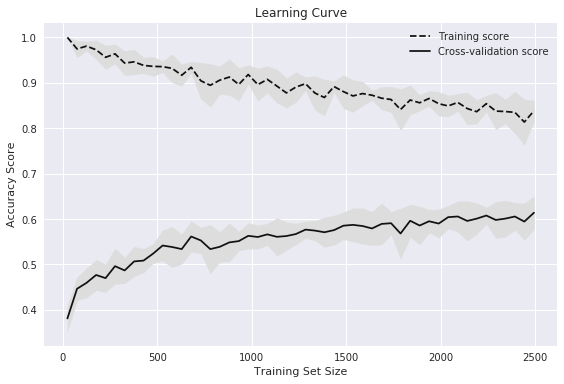

In [163]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(classifier2, features, outcomes,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Pipeline 2: Summary Results

In [83]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.8510600706713781


In [84]:
# classification report
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

          1       0.77      0.85      0.81      1853
          2       0.93      0.86      0.89      1922
          3       0.86      0.84      0.85      1885

avg / total       0.86      0.85      0.85      5660



In [85]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1577,  102,  174],
       [ 184, 1657,   81],
       [ 275,   27, 1583]])

### Pipeline 2: Confusion Matrix

Normalized confusion matrix
[[0.85 0.06 0.09]
 [0.1  0.86 0.04]
 [0.15 0.01 0.84]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


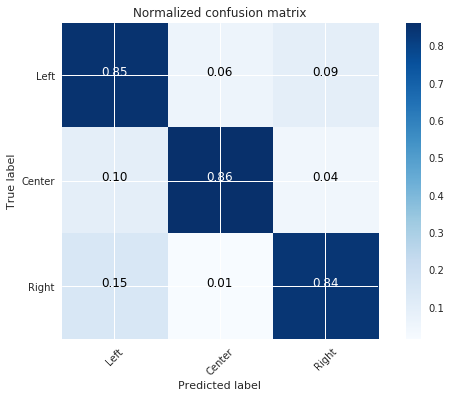

In [86]:
import matplotlib.pyplot as plt
import itertools

class_names = ['Left','Center','Right']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Early Data Exploration

### Multinomial Bayes

**Text Feature**

In [205]:
from sklearn.naive_bayes import MultinomialNB

In [206]:
# Run Multinomial Naive Bayes for Text Feature
text_nb = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.4, min_df = 0.05, sublinear_tf=True, norm='l2' )), 
                     ('clf', MultinomialNB()),])

In [207]:
text_nb.fit(X=counts_text, y=targets)  

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=0.05,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [208]:
pred_text = text_nb.predict(test_text)
accuracy = np.mean(pred_text == test_targets)
print(accuracy)

0.5421940928270043


In [209]:
print(classification_report(test_targets, pred_text))

             precision    recall  f1-score   support

          1       0.49      0.55      0.52       163
          2       0.64      0.57      0.60       143
          3       0.52      0.51      0.52       168

avg / total       0.55      0.54      0.54       474



**Source Feature**

In [210]:
# Run Multinomial Naive Bayes for Source
source_nb = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,5), sublinear_tf=True, norm='l2' )), 
                     ('clf', MultinomialNB()),])

In [211]:
source_nb.fit(counts_source, targets) 

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [212]:
pred_source = source_nb.predict(test_source)
accuracy = np.mean(pred_source == test_targets)
print(accuracy)

0.9873417721518988


In [213]:
print(classification_report(test_targets, pred_source))

             precision    recall  f1-score   support

          1       0.96      1.00      0.98       163
          2       1.00      0.98      0.99       143
          3       1.00      0.98      0.99       168

avg / total       0.99      0.99      0.99       474



**Sentiment Feature**

In [214]:
# Run Multinomial Naive Bayes for Sentiment Score
sent_nb = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
sent_nb.fit(counts_sent, targets) 

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [203]:
pred_sent = sent_nb.predict(test_sent)
accuracy = np.mean(pred_sent == test_targets)
print(accuracy)

0.3438818565400844


In [204]:
print(classification_report(test_targets, pred_sent))

             precision    recall  f1-score   support

          1       0.34      1.00      0.51       163
          2       0.00      0.00      0.00       143
          3       0.00      0.00      0.00       168

avg / total       0.12      0.34      0.18       474



/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
# Run Multinomial Naive Bayes for Sentiment Magnitude
mag_nb = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
mag_nb.fit(counts_mag, targets) 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [197]:
pred_mag = mag_nb.predict(test_mag)
accuracy = np.mean(pred_mag == test_targets)
print(accuracy)

0.3438818565400844


In [201]:
print(classification_report(test_targets, pred_mag))

             precision    recall  f1-score   support

          1       0.34      1.00      0.51       163
          2       0.00      0.00      0.00       143
          3       0.00      0.00      0.00       168

avg / total       0.12      0.34      0.18       474



/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Support Vector Machine

In [69]:
# Run Linear SVC
from sklearn.linear_model import SGDClassifier

text_SGD = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', sublinear_tf=True, norm='l2' )),
                     ('SVC', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])

In [70]:
text_SGD.fit(counts_text, targets)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [71]:
pred_text_SGD = text_SGD.predict(test_text)
accuracy = np.mean(pred_text_SGD == test_targets)
print(accuracy)

0.5319148936170213


In [72]:
print(classification_report(test_targets, pred_text_SGD))

             precision    recall  f1-score   support

          1       0.46      0.56      0.50       156
          2       0.62      0.70      0.66       155
          3       0.51      0.34      0.41       159

avg / total       0.53      0.53      0.52       470

